# Predicting Google stock prices Using GRU and LSTM Model

This use-case provides a demo of how RNN and GRU can be used to model time series data. In our use-case, we will use 'Google stock price' data to predict the number of future stock prices based on the available historical data. You have been given a dataset that contains google stock prices from 2013 to 2018. We have to model the time series data using RNN GRU sequential model.

**Similar examples with LSTM:**<br>
https://towardsdatascience.com/predicting-stock-prices-using-a-keras-lstm-model-4225457f0233<br>
https://towardsdatascience.com/lstm-time-series-forecasting-predicting-stock-prices-using-an-lstm-model-6223e9644a2f

**Understanding LSTM layer:**<br>
https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU
# Bidirectional,SimpleRNN
from tensorflow.keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [ ]:
# Some functions to help out with predictions
def predictions_plot(test,predicted):
    plt.plot(test, color='red',label='Real Google Stock Price')
    plt.plot(predicted, color='blue',label='Predicted Google Stock Price')
    plt.title('Google Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Google Stock Price')
    plt.legend()
    plt.show()

def rmse_return(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

### Collecting the Data
The dataset trainset.csv will be used for the demo. The dataset contains google stock prices from 2013 to 2018. It has been downloaded from the site https://www.kaggle.com/ptheru/google-stock-price-prediction-rnn/data

In [ ]:
# dataset = pd.read_csv('/content/trainset.csv', index_col='Date', parse_dates=['Date'])
dataset = pd.read_csv('trainset.csv', index_col='Date', parse_dates=['Date'])
print(dataset.shape)
dataset.head()

(1259, 6)


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-01-02,357.385559,361.151062,355.959839,359.288177,359.288177,5115500
2013-01-03,360.122742,363.600128,358.031342,359.496826,359.496826,4666500
2013-01-04,362.313507,368.339294,361.488861,366.600616,366.600616,5562800
2013-01-07,365.348755,367.301056,362.929504,365.001007,365.001007,3332900
2013-01-08,365.393463,365.771027,359.874359,364.280701,364.280701,3373900


In [ ]:
# Checking for missing values in Training and Test set
# training_set = dataset[:'2016']['High'].values  #taking the values from 'High' column
# test_set = dataset['2017':]['High'].values

# training_set = dataset[:'2016'].iloc[:,1:2].values  #taking the values from 'High' column
# test_set = dataset['2017':].iloc[:,1:2].values
training_set = dataset[:'2016']['High'].values.reshape(-1,1)  #taking the values from 'High' column
test_set = dataset['2017':]['High'].values.reshape(-1,1)
print(training_set.shape, test_set.shape, dataset.shape)
type(training_set), type(dataset)

(1008, 1) (251, 1) (1259, 6)


(numpy.ndarray, pandas.core.frame.DataFrame)

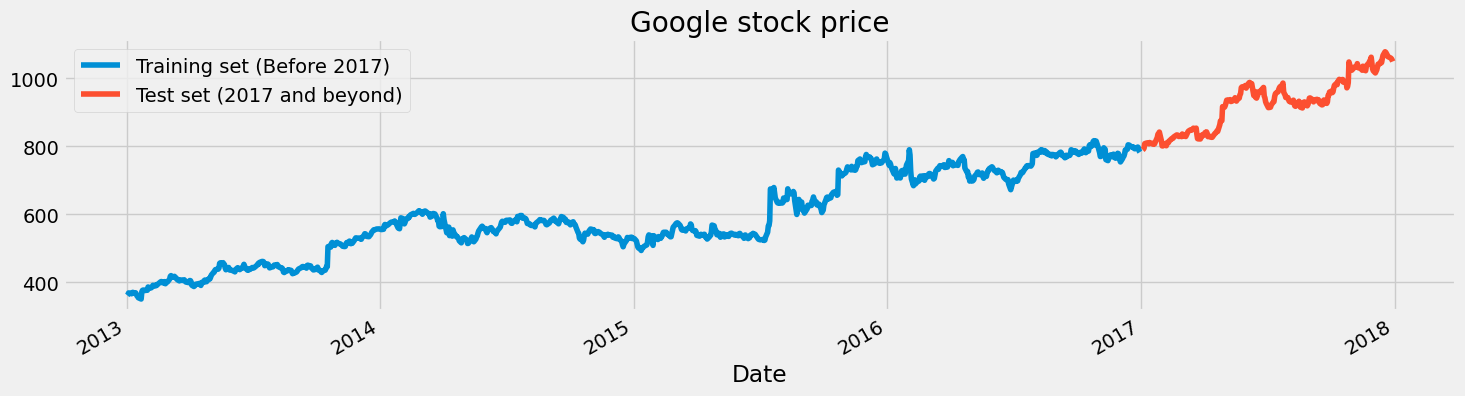

In [ ]:
# We have chosen 'High' attribute for prices. Let's see what it looks like
dataset["High"][:'2016'].plot(figsize=(16,4),legend=True)
dataset["High"]['2017':].plot(figsize=(16,4),legend=True)
plt.legend(['Training set (Before 2017)','Test set (2017 and beyond)'])
plt.title('Google stock price')
plt.show()

In [ ]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)
training_set_scaled.shape

(1008, 1)

In [ ]:
training_set[:10]

array([[361.151062],
       [363.600128],
       [368.339294],
       [367.301056],
       [365.771027],
       [366.789398],
       [370.092896],
       [368.816193],
       [368.701935],
       [365.125214]])

In [ ]:
training_set_scaled[:10]

array([[0.02307584],
       [0.02832809],
       [0.03849167],
       [0.03626508],
       [0.03298379],
       [0.03516778],
       [0.04225244],
       [0.03951443],
       [0.03926939],
       [0.03159878]])

* We create a data structure with 60 timesteps and 1 output
* One row of X_train will have 60 sequential values, and y_train will have the 61st value

In [ ]:

X_train = []
y_train = []
train_len = len(training_set_scaled)
for i in range(60,train_len):
    X_train.append(training_set_scaled[i-60:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
print(X_train.shape, y_train.shape)

(948, 60) (948,)


For being used by the RNN/GRU/LSTM layers, we need the shape of X_train to be: [ batch_size, time_steps, Features ]
* We will use the full data in a single batch, so batch size will be 948
* There are 60 time steps
* At each time step, the price is the feature, which is of 1-dimension. Compare this with a word, which can have higher dimension based on the word embedding chosen

In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))
print(X_train.shape)

(948, 60, 1)


## Gated Recurrent Units

In simple words, the GRU unit does not have to use a memory unit to control the flow of information like the LSTM unit. It can directly makes use of the all hidden states without any control. GRUs have fewer parameters and thus may train a bit faster or need less data to generalize. But, with large data, the LSTMs with higher expressiveness may lead to better results.

They are almost similar to LSTMs except that they have two gates: reset gate and update gate. Reset gate determines how to combine new input to previous memory and update gate determines how much of the previous state to keep. Update gate in GRU is what input gate and forget gate were in LSTM. We don't have the second non linearity in GRU before calculating the output, neither they have the output gate.

### Create the GRU model
* units - hidden layer dimension (no. of neurons)
* return sequences - when True, returns the output of each time step. Default False, returns the last output

In [ ]:
# The RNN & GRU architecture
model = Sequential()
# model.add(SimpleRNN(50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
# model.add(Dropout(0.2))
# model.add(SimpleRNN(50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
# model.add(Dropout(0.2))
model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
model.add(Dropout(0.2))
model.add(GRU(units=50, activation='tanh'))
model.add(Dropout(0.2))
# The output layer
model.add(Dense(units=1))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 60, 50)            7950      
                                                                 
 dropout (Dropout)           (None, 60, 50)            0         
                                                                 
 gru_1 (GRU)                 (None, 50)                15300     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 23,301
Trainable params: 23,301
Non-trainable params: 0
_________________________________________________________________


### Train the GRU model

There aren't definitive results on one optimization algorithm being "better" than another. The common wisdom (which needs to be taken with a pound of salt) has been that Adam requires less experimentation to get convergence on the first try than SGD and variants thereof. However, this is highly dataset/model dependent. More recently some groups have made the claim that despite training faster, models trained with Adam generalize worse to the validation or test sets. See https://arxiv.org/abs/1712.07628 for more information.

Gradient descent optimization algorithms - nice blog - https://ruder.io/optimizing-gradient-descent/

In [ ]:
# Compiling the GRU
model.compile(optimizer='adam',loss='mean_squared_error')
# Fitting to the training set
model.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50
7/7 [==============================] - 9s 13ms/step - loss: 0.2788
Epoch 2/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0295
Epoch 3/50
7/7 [==============================] - 0s 11ms/step - loss: 0.0356
Epoch 4/50
7/7 [==============================] - 0s 12ms/step - loss: 0.0121
Epoch 5/50
7/7 [==============================] - 0s 10ms/step - loss: 0.0166
Epoch 6/50
7/7 [==============================] - 0s 10ms/step - loss: 0.0088
Epoch 7/50
7/7 [==============================] - 0s 10ms/step - loss: 0.0086
Epoch 8/50
7/7 [==============================] - 0s 10ms/step - loss: 0.0063
Epoch 9/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0065
Epoch 10/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0057
Epoch 11/50
7/7 [==============================] - 0s 8ms/step - loss: 0.0058
Epoch 12/50
7/7 [==============================] - 0s 10ms/step - loss: 0.0057
Epoch 13/50
7/7 [==============================] - 0s 9ms/step -

### Test the GRU model

* We use the previous 60 days’ stock prices to predict the next-day price
* So, we need the 60 days’ price before the 1st date in the test dataset.
* Accordingly, we create the input for prediction, index starting from the date 60 days before the first date in the test dataset.

In [ ]:
# dataset_total = pd.concat((dataset["High"][:'2017'],dataset["High"]['2017':]),axis=0)
dataset_total = dataset["High"]
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values ## last 60 values of train_data + all values of test_data
print(len(dataset_total), len(test_set))
print(inputs.shape)
inputs = inputs.reshape(-1,1)
print(inputs.shape)
inputs  = sc.transform(inputs)

1259 251
(311,)
(311, 1)


In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,len(inputs)):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
print(X_test.shape)
#X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
X_test = np.expand_dims(X_test, 2)
print(X_test.shape)

(251, 60)
(251, 60, 1)


In [ ]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

8/8 [==============================] - 1s 4ms/step


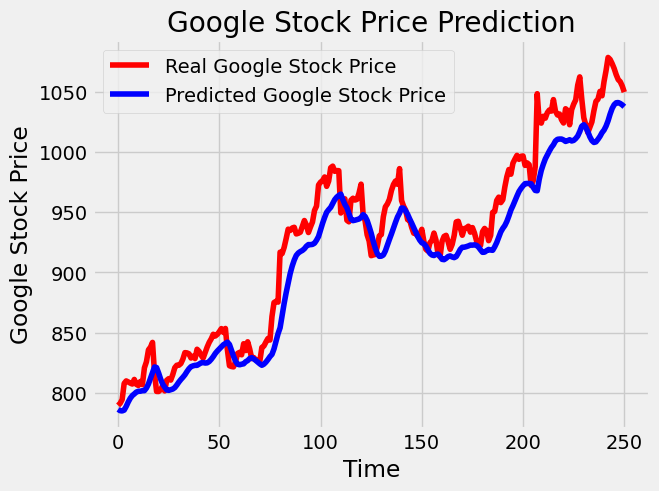

In [ ]:
# Visualizing the results for GRU
predictions_plot(test_set,predicted_stock_price)

In [ ]:
# Evaluating GRU
rmse_return(test_set,predicted_stock_price)

The root mean squared error is 22.994618271899064.


## LSTM Model

* Note for the LSTM layer, units is the number of LSTM neurons in the layer. 50 neurons will give the model high dimensionality, enough to capture the upwards and downward trends
* return_sequences is True as we need to add another LSTM layer after the current one. Note the last LSTM layer, return_sequences is False as we will not add more LSTM layers
* input_shape corresponds to the number of time stamps and the number of indicators
* For dropout, 20% of 50 neurons will be ignored randomly during each iteration of training
* Finally, add the output layer. The output dimension is 1 since we are predicting 1 price each time

In [ ]:
model = Sequential()
#add 1st lstm layer
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(rate = 0.2))

##add 2nd lstm layer: 50 neurons
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(rate = 0.2))

##add 3rd lstm layer
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(rate = 0.2))

##add 4th lstm layer
model.add(LSTM(units = 50, return_sequences = False))
model.add(Dropout(rate = 0.2))

##add output layer
model.add(Dense(units = 1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 50)            10400     
                                                                 
 dropout_2 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_3 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)               

### Calculating the number of parameters to learn

![image.png](attachment:ed42f63c-8218-459d-bd3a-a7b7b6b81f22.png)
![image.png](attachment:a60a0cf7-0180-452c-9aa9-61cbd34dcfdc.png)

In [ ]:
lstmLayer = 0
print('LSTM Layer:', model.layers[lstmLayer].name)
LSTMoutputDimension = 50
if lstmLayer == 0:
    features = X_train.shape[2]
else:
    features = LSTMoutputDimension

W = model.layers[lstmLayer].get_weights()[0]
U = model.layers[lstmLayer].get_weights()[1]
b = model.layers[lstmLayer].get_weights()[2]

print("Input [batch_size, timesteps, feature] ", X_train.shape)
print("x -> Input feature/dimension", features)
print("h -> Number of Hidden States/LSTM units (cells)/dimensionality of the output space", LSTMoutputDimension)
print("----Shapes of Matrices and Vecors:-----------")
print("W", W.shape)
print("U", U.shape)
print("b", b.shape)
print("----Parameters-------------------------------")
print("W", W.size, ' 4*features*LSTMoutputDimension ', 4*features*LSTMoutputDimension)
print("U", U.size, ' 4*LSTMoutputDimension*LSTMoutputDimension ', 4*LSTMoutputDimension*LSTMoutputDimension)
print("b", b.size , ' 4*LSTMoutputDimension ', 4*LSTMoutputDimension)
print("Total Parameter Number: W+ U + b " , W.size+ U.size + b.size)
print("Total Parameter Number: 4 × ((x + h) × h +h) " ,
      4* ((features+LSTMoutputDimension)*LSTMoutputDimension+LSTMoutputDimension))


### Training the model

In [ ]:
model.compile(optimizer='adam',loss='mean_squared_error')
model.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50
7/7 [==============================] - 8s 23ms/step - loss: 0.1696
Epoch 2/50
7/7 [==============================] - 0s 23ms/step - loss: 0.0353
Epoch 3/50
7/7 [==============================] - 0s 16ms/step - loss: 0.0213
Epoch 4/50
7/7 [==============================] - 0s 16ms/step - loss: 0.0152
Epoch 5/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0125
Epoch 6/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0095
Epoch 7/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0075
Epoch 8/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0071
Epoch 9/50
7/7 [==============================] - 0s 15ms/step - loss: 0.0071
Epoch 10/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0070
Epoch 11/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0068
Epoch 12/50
7/7 [==============================] - 0s 14ms/step - loss: 0.0072
Epoch 13/50
7/7 [==============================] - 0s 15ms/st

(1008, 1) (251, 1) (1259, 6)

In [ ]:
# dataset_total = pd.concat((dataset["High"][:'2017'],dataset["High"]['2017':]),axis=0)
dataset_total = dataset["High"]
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values ## last 60 values of train_data + all values of test_data
print(len(dataset_total), len(test_set))
print(inputs.shape)
inputs = inputs.reshape(-1,1)
print(inputs.shape)
inputs  = sc.transform(inputs)

1259 251
(311,)
(311, 1)


In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,len(inputs)):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
print(X_test.shape)
#X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
X_test = np.expand_dims(X_test, 2)
print(X_test.shape)

(251, 60)
(251, 60, 1)


In [ ]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

8/8 [==============================] - 1s 8ms/step


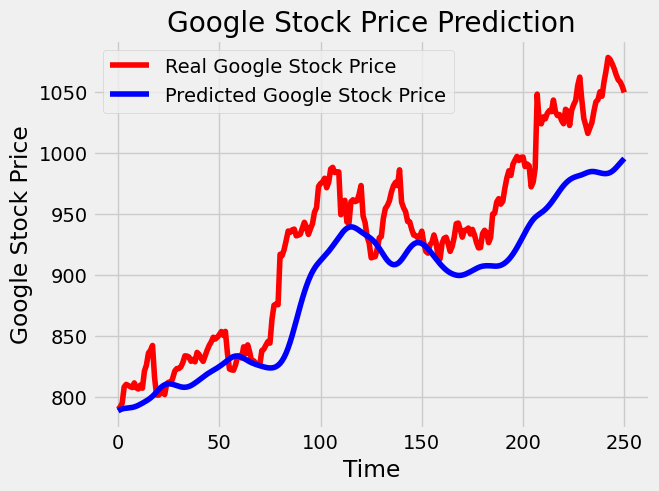

In [ ]:
# Visualizing the results for GRU
predictions_plot(test_set,predicted_stock_price)

In [ ]:
print(test_set[25],predicted_stock_price[25])

[811.840027] [810.49786]


In [ ]:
# Evaluating GRU
rmse_return(test_set,predicted_stock_price)

The root mean squared error is 45.02290817229662.
